В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install mlxtend

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [4]:
!git clone https://github.com/andrikoks/DSML-course-hometasks

Cloning into 'DSML-course-hometasks'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 64 (delta 28), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 7.34 MiB | 6.68 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [5]:
cd DSML-course-hometasks/

/content/DSML-course-hometasks


In [6]:
from process_bank_churn import preprocess_data

In [7]:
raw_df = pd.read_csv('train.csv')

In [8]:
data = preprocess_data(raw_df)

In [9]:
data

{'train_X':        CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
 7180      0.599045  0.214286     0.1  0.626382       0.000000        1.0   
 10393     0.603819  0.375000     0.2  0.848836       0.000000        1.0   
 80        0.653938  0.303571     0.6  0.554522       0.333333        1.0   
 3365      0.568019  0.714286     0.0  0.000000       0.333333        0.0   
 12236     0.658711  0.053571     0.3  0.000000       0.333333        1.0   
 ...            ...       ...     ...       ...            ...        ...   
 9493      0.482100  0.267857     0.4  0.000000       0.333333        0.0   
 8463      0.577566  0.392857     0.1  0.000000       0.000000        1.0   
 8143      0.453461  0.196429     0.8  0.000000       0.333333        1.0   
 11512     0.379475  0.428571     0.7  0.000000       0.333333        0.0   
 9360      0.272076  0.160714     0.2  0.000000       0.333333        1.0   
 
        IsActiveMember  EstimatedSalary  Geography_France  Geog

In [10]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
scaler = data['scaler']
encoder = data['encoder']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [11]:
knn = KNeighborsClassifier()

knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [20]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, model, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.0)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.4f}')


In [21]:
compute_auroc_and_build_roc(X_train, train_targets, knn, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, knn, 'Val')

AUROC for Training: 0.9559
AUROC for Val: 0.8526


Модель досить таки припасувалась до тренувальних даних, але на валідаційних AUROC кращий ніж на Decision Tree у першій спробі

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [15]:
?GridSearchCV

In [18]:
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [19]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.8671666666666666


In [22]:
compute_auroc_and_build_roc(X_train, train_targets, knn_gs, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, knn_gs, 'Val')

AUROC for Training: 0.9407
AUROC for Val: 0.8809


In [30]:
compute_auroc_and_build_roc(X_train, train_targets, knn_best, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, knn_best, 'Val')

AUROC for Training: 0.9407
AUROC for Val: 0.8809


На валідаційному сеті покращився AUROC та все ще не такий, як був на найкращому дереві

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
%%time
tree = DecisionTreeClassifier(random_state=42)
params_tree = {'max_depth': np.arange(1, 22, 2), 'max_leaf_nodes': np.arange(2, 11, 1)}
params_tree_gs = GridSearchCV(tree, params_tree, cv=3, scoring='roc_auc')
params_tree_gs.fit(X_train, train_targets)

CPU times: user 6.14 s, sys: 411 µs, total: 6.14 s
Wall time: 6.12 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc')

In [27]:
tree_best = params_tree_gs.best_estimator_
print(params_tree_gs.best_params_, params_tree_gs.best_score_)

{'max_depth': 5, 'max_leaf_nodes': 10} 0.9013929183420709


In [29]:
compute_auroc_and_build_roc(X_train, train_targets, tree_best, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, tree_best, 'Val')

AUROC for Training: 0.9015
AUROC for Val: 0.9002


4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [31]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [33]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [35]:
tree = DecisionTreeClassifier()

In [36]:
params_tree_rs = RandomizedSearchCV(tree, params_dt, cv=3, scoring='roc_auc', random_state=42)
params_tree_rs.fit(X_train, train_targets)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [37]:
dt_random_search_best = params_tree_rs.best_estimator_
print(params_tree_rs.best_params_, params_tree_rs.best_score_)

{'splitter': 'random', 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_leaf_nodes': 16, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'} 0.8948742656369776


In [38]:
compute_auroc_and_build_roc(X_train, train_targets, dt_random_search_best, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, dt_random_search_best, 'Val')

AUROC for Training: 0.8893
AUROC for Val: 0.8820


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [39]:
new_data = pd.read_csv('test.csv', index_col=0)

In [40]:
from process_bank_churn import preprocess_new_data

In [41]:
test = preprocess_new_data(new_data, scaler, encoder)

In [42]:
probability = dt_random_search_best.predict_proba(test)[:,1]
probability

array([0.20498301, 0.01505792, 0.04584222, ..., 0.03426676, 0.13103953,
       0.03426676])

In [43]:
test['Exited'] = probability

In [45]:
submission = pd.read_csv('sample_submission.csv')

submission[:5]

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [46]:
submission['Exited'] = test['Exited'].values
submission.head()

,id,Exited
0,15000,0.204983
1,15001,0.015058
2,15002,0.045842
3,15003,0.357860
4,15004,0.045842


In [47]:
submission.to_csv('submission_decision_dt_random_search_best.csv', index=False)

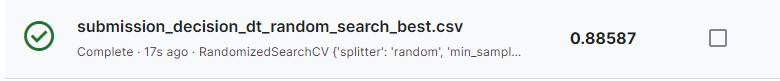

In [48]:
test = preprocess_new_data(new_data, scaler, encoder)

In [49]:
probability = tree_best.predict_proba(test)[:,1]
probability

array([0.1443299, 0.0208616, 0.0208616, ..., 0.0208616, 0.1443299,
       0.1443299])

In [50]:
test['Exited'] = probability

In [51]:
submission = pd.read_csv('sample_submission.csv')

submission[:5]

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [52]:
submission['Exited'] = test['Exited'].values
submission.head()

,id,Exited
0,15000,0.144330
1,15001,0.020862
2,15002,0.020862
3,15003,0.618718
4,15004,0.020862


In [53]:
submission.to_csv('submission_tree_gs.csv', index=False)

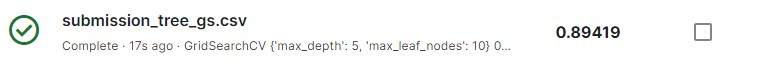

In [54]:
test = preprocess_new_data(new_data, scaler, encoder)

In [55]:
probability = knn_best.predict_proba(test)[:,1]
probability

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.22222222])

In [56]:
test['Exited'] = probability

In [57]:
submission = pd.read_csv('sample_submission.csv')

submission[:5]

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [58]:
submission['Exited'] = test['Exited'].values
submission.head()

,id,Exited
0,15000,0.000000
1,15001,0.000000
2,15002,0.000000
3,15003,0.555556
4,15004,0.111111


In [60]:
submission.to_csv('submission_knn.csv', index=False)

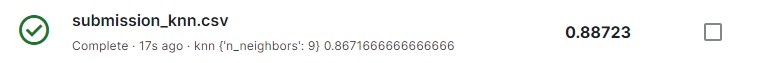